# Bird Strike Analysis Project

This notebook analyzes bird strike incidents, focusing on the relationships between variables such as flight phase, altitude, wildlife size, and damage occurrence. The analysis includes data cleaning, visualization, and a machine learning model for damage prediction.


In [9]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder


## Data Loading and Cleaning
The dataset contains variables such as `Altitude`, `FlightPhase`, `WildlifeSize`, `Damage`, and `Cost`. Initial data cleaning involves handling missing values and converting data types for numerical analysis.



In [10]:
# Load the dataset
bird_data = pd.read_csv('Bird_strikes.csv')

# Clean the 'Cost' column: remove commas and convert to numeric, coercing errors to NaN
bird_data['Cost'] = pd.to_numeric(
    bird_data['Cost'].str.replace(',', ''), errors='coerce'
)


## Cost Analysis by Wildlife Size
Group the data by `WildlifeSize` to calculate statistical measures for `Cost` (max, min, mean, median).


In [11]:
# Group by 'WildlifeSize' and calculate max, min, mean, and median for 'Cost'
damage_cost_summary = bird_data.groupby('WildlifeSize')['Cost'].agg(['max', 'min', 'mean', 'median'])

# Display the cleaned summary
print(damage_cost_summary)


                   max  min          mean  median
WildlifeSize                                     
Large         12397751    0  39226.641346     0.0
Medium         3463326    0   6124.238167     0.0
Small          5704387    0   1355.166667     0.0


## Total Incidents by Altitude Bin
Visualize the total number of incidents grouped by `AltitudeBin`.


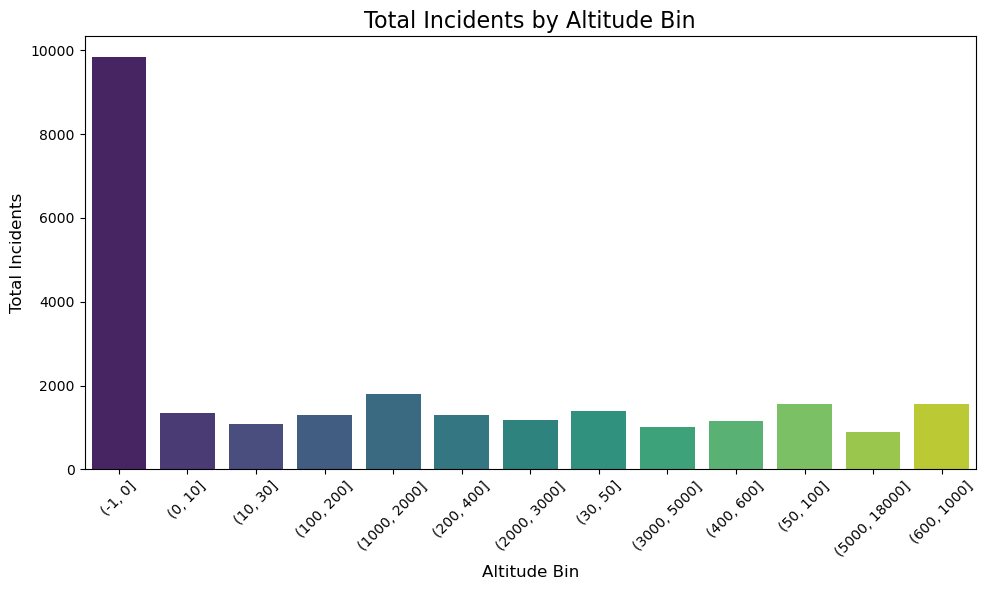

In [12]:
# Extract both negative and positive starting numbers from AltitudeBin
bird_data['AltitudeBin_Start'] = bird_data['AltitudeBin'].str.extract(r'(-?\d+)').astype(float)

# Group by AltitudeBin and count total incidents
altitude_damage_stats = bird_data.groupby('AltitudeBin').size().reset_index(name='Incident_Count')

# Visualization with updated Seaborn behavior
plt.figure(figsize=(10, 6))
sns.barplot(
    x='AltitudeBin', 
    y='Incident_Count', 
    data=altitude_damage_stats, 
    hue='AltitudeBin',  # Assign `x` to `hue`
    palette='viridis', 
    legend=False  # Disable legend as it's redundant in this case
)
plt.title('Total Incidents by Altitude Bin', fontsize=16)
plt.xlabel('Altitude Bin', fontsize=12)
plt.ylabel('Total Incidents', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Proportion of Incidents by Flight Phase
Display the percentage of incidents for each flight phase using a pie chart.


---

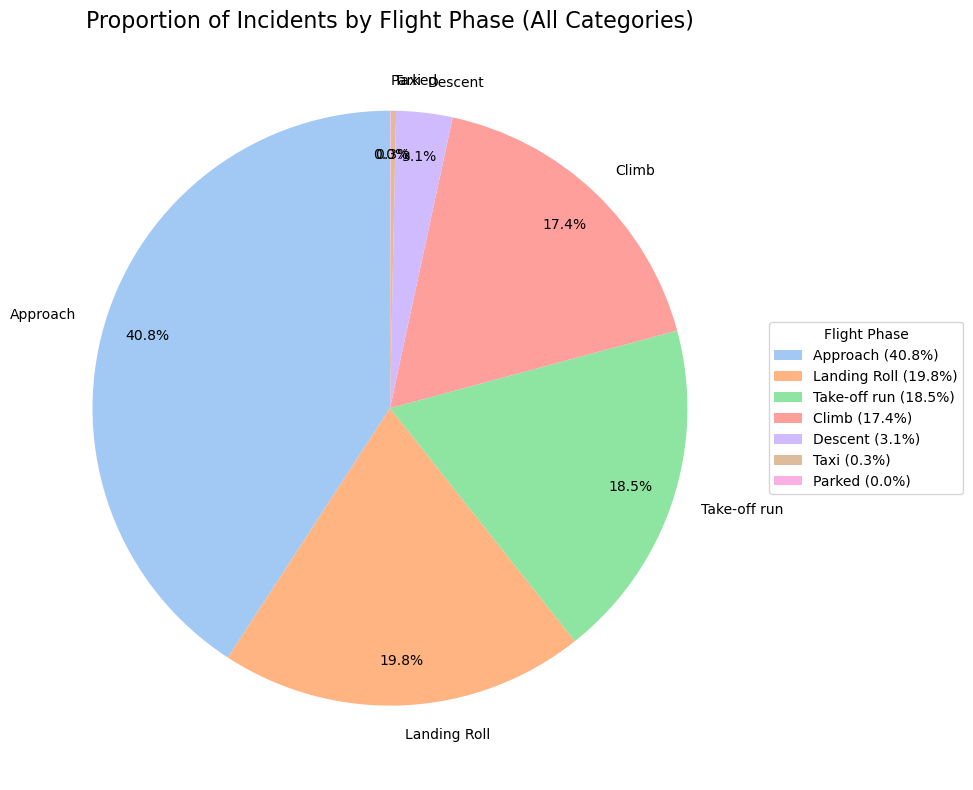

In [13]:
# Calculate proportions for FlightPhase
flight_phase_stats = bird_data['FlightPhase'].value_counts(normalize=True) * 100

# Simplified autopct function
def autopct_custom(pct):
    return f'{pct:.1f}%'

# Plot the pie chart with all categories
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(
    flight_phase_stats.values,
    labels=flight_phase_stats.index,
    autopct=autopct_custom,
    startangle=90,
    colors=sns.color_palette('pastel', len(flight_phase_stats)),
    labeldistance=1.1,  # Slightly adjust label distance
    pctdistance=0.85    # Adjust percentage text distance
)

# Add legend
plt.legend(
    wedges, 
    [f"{label} ({value:.1f}%)" for label, value in flight_phase_stats.items()],
    title="Flight Phase",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=10
)

# Title and show
plt.title('Proportion of Incidents by Flight Phase (All Categories)', fontsize=16)
plt.tight_layout()
plt.show()


## Damage Distribution by Wildlife Size
Use a stacked bar chart to compare damage occurrence across wildlife size categories.



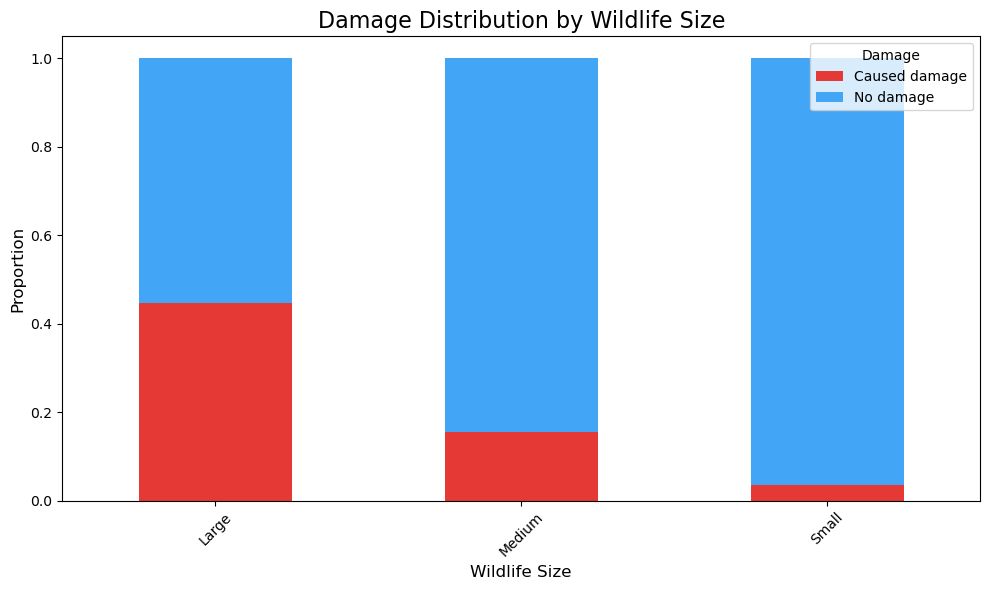

In [14]:

# Group by Wildlife Size and Damage Label
wildlife_damage_stats = bird_data.groupby(['WildlifeSize', 'Damage']).size().reset_index(name='Count')

# Pivot the data for stacked proportions
wildlife_damage_pivot = wildlife_damage_stats.pivot(index='WildlifeSize', columns='Damage', values='Count').fillna(0)
wildlife_damage_proportions = wildlife_damage_pivot.div(wildlife_damage_pivot.sum(axis=1), axis=0)

# Plotting the stacked bar chart
wildlife_damage_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#E53935', '#42A5F5'])
plt.title('Damage Distribution by Wildlife Size', fontsize=16)
plt.xlabel('Wildlife Size', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Damage')
plt.tight_layout()
plt.show()


## Predicting Damage Occurrence
Train a machine learning model (K-Nearest Neighbors, KNN) to predict damage occurrence based on wildlife size, altitude, and flight phase.  
The model achieved 91% accuracy, but due to the class imbalance in the dataset, recall and F1-score for "Damage" cases remained low. This highlights the inherent limitations of the data.



Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4606
           1       0.50      0.14      0.22       480

    accuracy                           0.91      5086
   macro avg       0.71      0.56      0.58      5086
weighted avg       0.88      0.91      0.88      5086

Accuracy: 0.91
Recall: 0.14
F1 Score: 0.22


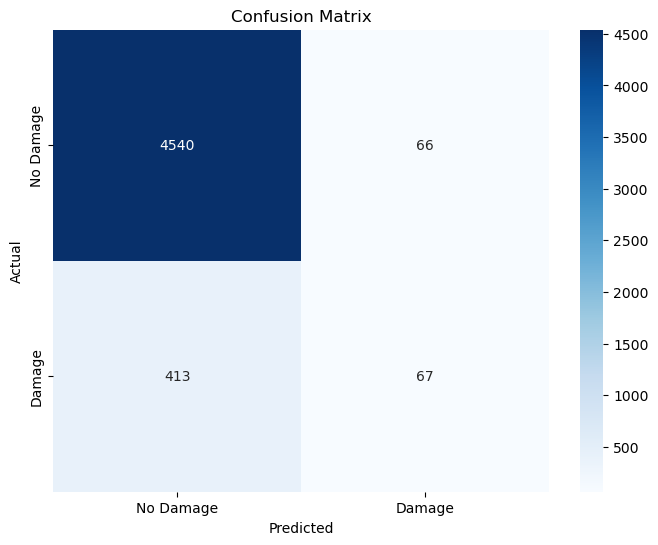

In [ ]:
# Encode categorical variables
bird_data['WildlifeSize_Encoded'] = LabelEncoder().fit_transform(bird_data['WildlifeSize'])
bird_data['FlightPhase_Encoded'] = LabelEncoder().fit_transform(bird_data['FlightPhase'])

# Select features and target variable
X = bird_data[['WildlifeSize_Encoded', 'Altitude', 'FlightPhase_Encoded']].fillna(bird_data[['Altitude']].median())
y = bird_data['Damage'].apply(lambda x: 1 if x == 'Caused damage' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # Adjust 'n_neighbors' as needed
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Damage', 'Damage'], 
            yticklabels=['No Damage', 'Damage'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()